In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

In [2]:
# matplotlib settings to match LaTeX fonts and style
latex_path = shutil.which("latex")
print("LaTeX found at:", latex_path if latex_path else "Not found in PATH")

mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",  # Computer Modern serif
        "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{amsmath,amssymb,bm}",
        "axes.labelsize": 9,  # adjust to match \small or \normalsize
        "font.size": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    }
)


def set_size(width_pt=455, fraction=1, aspect=0.62):
    """Set figure dimensions to fit LaTeX doc."""
    inches_per_pt = 1 / 72.27
    width_in = width_pt * inches_per_pt * fraction
    height_in = width_in * aspect
    return (width_in, height_in)

LaTeX found at: /Library/TeX/texbin/latex


In [4]:
def get_df(model, ra, seed):
    path = f"results/{model}/ra{ra}-{seed}.csv"
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    df["model"] = model
    df["ra"] = ra
    df["seed"] = seed
    return df


models = ["2d-lran", "2d-fno2d", "2d-fno3d", "2d-unet"]
ras = [300000, 1000000, 3000000, 10000000]
seeds = [0, 1, 2, 3, 4]

metric = "nrsse"

# collect all data into one big DataFrame
df = pd.concat(
    [get_df(m, r, seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)


def model2name(model):
    if model == "2d-lran":
        return "LRAN"
    elif model == "2d-fno2d":
        return "FNO-2D"
    elif model == "2d-fno3d":
        return "FNO-3D"
    elif model == "2d-unet":
        return "U-Net"
    else:
        return model

# Prediction Error vs Ra

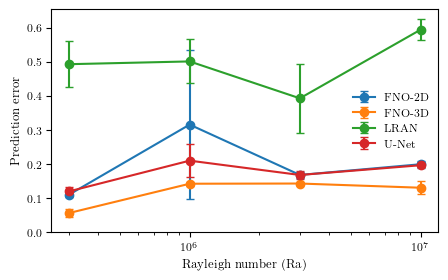

In [6]:
# TODO debug filter; filter out steps above 30
# df = df[df["step"] <= 30]
# df = df[df["ra"] >= 300000]

# 1) collapse each run (model, ra, seed) to a single scalar: mean error over all samples & timesteps
per_run = (
    df.groupby(["model", "ra", "seed"], as_index=False)[metric]
    .mean()
    .rename(columns={metric: "run_mean"})
)

# 2) aggregate across seeds (between-run variability)
summary = (
    per_run.groupby(["model", "ra"])["run_mean"]
    .agg(mu="mean", sigma="std", n_runs="count", best="min", median="median")
    .reset_index()
)

# standard error and 95% CI for convenience
# summary["se"] = summary["sigma"] / np.sqrt(summary["n_runs"]).replace(0, np.nan)
# summary["ci95"] = 1.96 * summary["se"]

# nice sort by Ra (numeric) and model
summary = summary.sort_values(["model", "ra"]).reset_index(drop=True)
fig, ax = plt.subplots(figsize=set_size(455, fraction=0.7))

for model, sub in summary.groupby("model"):
    x = sub["ra"].values
    y = sub["mu"].values
    yerr = sub["sigma"].values
    ax.errorbar(x, y, yerr=yerr, marker="o", capsize=3, label=model2name(model))

ax.set_xlabel(r"Rayleigh number ($\mathrm{Ra}$)")
ax.set_ylabel(r"Prediction error")
ax.set_xscale("log")
ax.set_ylim(bottom=0)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig("figures/2d_error2ra.pdf")

# Prediction Error vs Time in Sequence

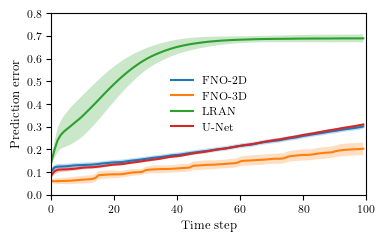

In [11]:
RA = 10_000_000

d = df.copy()
d = d[d["ra"] == RA]

# 1) Per-run, per-time mean and std over samples (within-run stats)
# count is helpful for pooled std later
per_run_time = (
    d.groupby(["model", "seed", "step"])[metric].agg(run_mean="mean").reset_index()
)

# 2) Aggregate across seeds at each time
across = (
    per_run_time.groupby(["model", "step"])["run_mean"]
    .agg(mu="mean", sigma="std")
    .reset_index()
    .sort_values(["model", "step"])
    .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6))

for model, sub in across.groupby("model"):
    x = sub["step"].values
    mu = sub["mu"].values
    sig = sub["sigma"].values
    plt.plot(x, mu, label=model2name(model))
    plt.fill_between(x, mu - sig, mu + sig, alpha=0.25)

ax.set_xlabel(r"Time step")
ax.set_ylabel(r"Prediction error")
# ax.set_title(rf"Rayleigh number ($\mathrm{{Ra}}={RA:.0e}$)")
ax.set_ylim(bottom=0, top=0.8)
ax.set_xlim(left=0, right=100)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig(f"figures/2d_ra{RA}.pdf")

# Physics

In [4]:
def get_result_df(model, table, ra, seed):
    path = f"results/{model}/{table}/ra{ra}-{seed}.csv"
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    df["model"] = model
    df["ra"] = ra
    df["seed"] = seed
    return df


models = ["2d-fno3d", "2d-lran"]
ras = [3000000]
seeds = [0, 1, 2]

# collect all data into one big DataFrame
df_metrics = pd.concat(
    [
        get_result_df(m, "metrics", ra, seed)
        for m in models
        for ra in ras
        for seed in seeds
    ],
    ignore_index=True,
)
print(df_metrics.columns)

Index(['batch_idx', 'sample_idx', 'step', 'rmse', 'nrsse', 'loss', 'nu_pred',
       'nu_target', 'kin_pred', 'kin_target', 'div_pred_rms', 'div_target_rms',
       'model', 'ra', 'seed'],
      dtype='object')


### Divergence

In [5]:
# compute div error
df_metrics["err"] = (df_metrics["div_target_rms"] - df_metrics["div_pred_rms"]).abs()

df_div = df_metrics.groupby(["model"], as_index=False).agg(
    pred_mean=("div_pred_rms", "mean"),
    pred_std=("div_pred_rms", "std"),
    target_mean=("div_target_rms", "mean"),
    target_std=("div_target_rms", "std"),
    err_mean=("err", "mean"),
    err_std=("err", "std"),
)


print(df_div)

      model  pred_mean  pred_std  target_mean  target_std  err_mean   err_std
0  2d-fno3d   0.232147  0.012613     0.210992    0.011433  0.021231  0.010054
1   2d-lran   0.228520  0.051791     0.212520    0.011481  0.027214  0.048603
